In [52]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from collections import Counter
from sklearn.metrics import rand_score, confusion_matrix

In [53]:
# utility function to calculate purity
def calculate_purity(true_labels, predicted_labels):
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    purity = np.sum(np.max(confusion_mat, axis=0)) / np.sum(confusion_mat)
    return purity

# utility function to calculate digit frequency in a cluster
def digit_frequency_in_cluster(cluster_labels, Y):
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        true_labels_in_cluster = Y[cluster_labels == cluster]
        digit_counts = Counter(true_labels_in_cluster)
        print(f"Cluster {cluster}:")
        for digit, count in digit_counts.items():
            print(f"Digit {digit}: {count}")

**Q2 Part- A**

**Step - 1 : Loading training and testing data**

In [54]:
def randomly_sample_2500_from_each_class(X, Y):
    X_train = []
    Y_train = []
    Y = Y.ravel()
    
    for class_label in range(1,11):
        class_indices = np.where(Y == class_label)[0]
        sampled_indices = np.random.choice(class_indices, 2500, replace=False)        
        # print(sampled_indices)
        X_train.append(X[:, :, :, sampled_indices])
        Y_train.append(Y[sampled_indices])
        
    X_train = np.concatenate(X_train, axis=-1)
    Y_train = np.concatenate(Y_train)
    return X_train, Y_train

In [55]:
mnist_train_data = scipy.io.loadmat('D:/SVHN_Dataset/train_32x32.mat')
X = mnist_train_data['X'].astype('double')  # Training data
Y = mnist_train_data['y']  # Training labels

X, Y = randomly_sample_2500_from_each_class(X, Y)

X = X.transpose(3, 0, 1, 2)
X = X.reshape(X.shape[0], -1)
X = X / 255
X_mean = np.mean(X, axis=0)

# standardizing the data 
X -= X_mean 

print('X:', X.shape)
print('Y:', Y.shape)
print(f'X_mean: - {X_mean.shape}')

X: (25000, 3072)
Y: (25000,)
X_mean: - (3072,)


In [56]:
mnist_test_data = scipy.io.loadmat('D:/SVHN_Dataset/test_32x32.mat')
X_test = mnist_test_data['X'].astype('double')
Y_test = mnist_test_data['y']


X_test = X_test.transpose(3, 0, 1, 2)
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = X_test / 255
# standardizing the data 
X_test -= X_mean 


print(f'X_test - {X_test.shape}')
print(f'Y_test - {Y_test.shape}')

X_test - (26032, 3072)
Y_test - (26032, 1)


**Case - 1: Applying K-means on raw data**

In [ ]:
# Perform k-means clustering with k=10 on raw data
kmeans_raw =  KMeans(n_clusters=10, random_state=42)
kmeans_raw.fit(X)
print(f'Number of clusters formed - {len(kmeans_raw.cluster_centers_)}')

C:\Users\sanya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Case - 2: Applying k-means on dimentionaly reduced data obtained from top 10 Principle Components (PCs)**

In [7]:
# Perform PCA to get the top 10 eigenvectors
pca_top_10 = PCA(n_components=10)
pca_top_10.fit(X)
X_pca_top_10 = pca_top_10.fit_transform(X)
X_pca_top_10.shape

(25000, 10)

In [8]:
# Perform k-means clustering with k=10 on PCA-transformed data (dimension from part a)
kmeans_pca_top_10 = KMeans( n_clusters=10, random_state=42)
kmeans_pca_top_10.fit(X_pca_top_10)
labels_pca_top_10 = kmeans_pca_top_10.labels_
print(f'Number of clusters formed - {len(kmeans_pca_top_10.cluster_centers_)}')

C:\Users\sanya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters formed - 10


**Case - 3: Applying k-means on dimentionaly reduced data obtained from top 27 PCs**

In [9]:
# Perform PCA to get the top 27 eigenvectors
pca_top_27 = PCA(n_components=27)
pca_top_27.fit(X)
X_pca_top_27 = pca_top_27.fit_transform(X)
X_pca_top_27.shape

(25000, 27)

In [10]:
# Perform k-means clustering with k=10 on PCA-transformed data (dimension 10 from part b)
kmeans_pca_top_27= KMeans(n_clusters=10, random_state=42)
kmeans_pca_top_27.fit(X_pca_top_27)
labels_pca_top_27 = kmeans_pca_top_27.labels_
print(f'Number of clusters formed - {len(kmeans_pca_top_27.cluster_centers_)}')

C:\Users\sanya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters formed - 10


**Finding closest image of each cluster centroid**

In [11]:
# Function to find the image closest to the centroid for each cluster
def find_closest_images(cluster_centers, data):
    closest_images = []
    for center in cluster_centers:
        closest_index = pairwise_distances_argmin_min(center.reshape(1, -1), data)[0][0]
        closest_images.append(data[closest_index])
    return closest_images

# Find the image closest to the centroid for each cluster
closest_images_raw = find_closest_images(kmeans_raw.cluster_centers_, X)
closest_images_pca_top_10 = find_closest_images(pca_top_10.inverse_transform(kmeans_pca_top_10.cluster_centers_), X)
closest_images_pca_top_27 = find_closest_images(pca_top_27.inverse_transform(kmeans_pca_top_27.cluster_centers_), X)


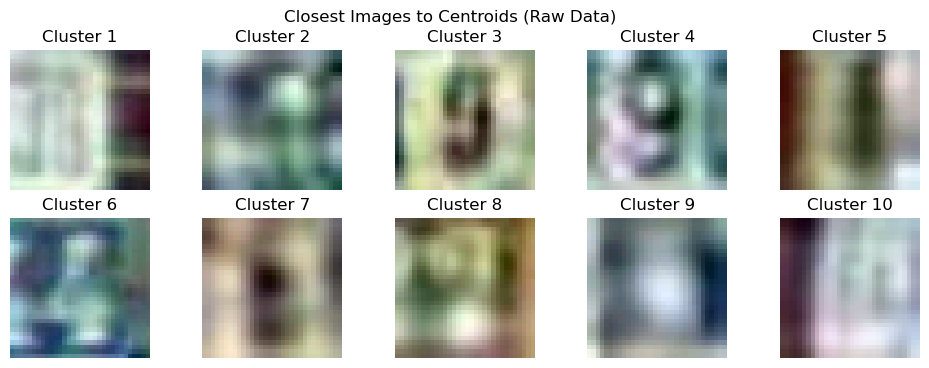

****************************************************************************************************************


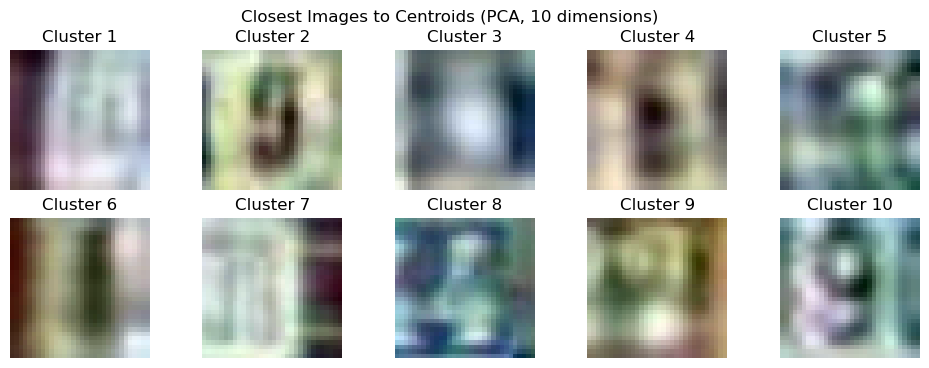

****************************************************************************************************************


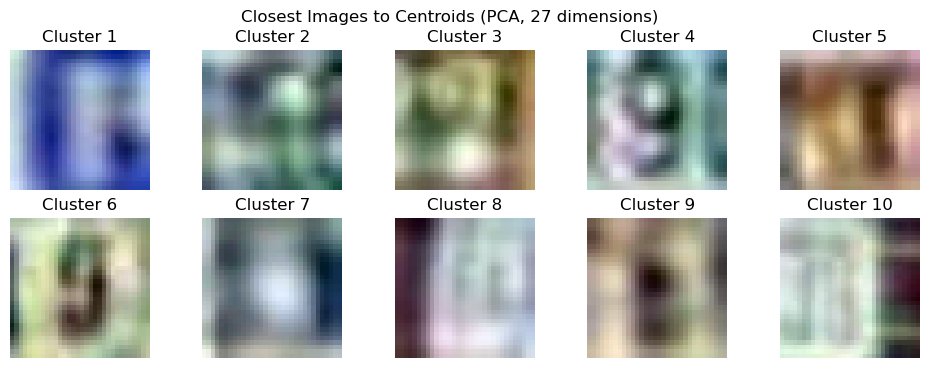

In [12]:
def plot_closest_images(images, title):
    plt.figure(figsize=(12, 4))
    for i, img in enumerate(images):
        plt.subplot(2, 5, i + 1)
        normalized_image = (img - img.min()) / (img.max() - img.min())
        plt.imshow(normalized_image.reshape(32, 32, 3))
        plt.title(f'Cluster {i + 1}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_closest_images(closest_images_raw, 'Closest Images to Centroids (Raw Data)')
print('****************************************************************************************************************')
plot_closest_images(closest_images_pca_top_10, f'Closest Images to Centroids (PCA, 10 dimensions)')
print('****************************************************************************************************************')
plot_closest_images(closest_images_pca_top_27, f'Closest Images to Centroids (PCA, 27 dimensions)')

**Case- 1: Using raw data - Frequency of each digit in every cluster: -**

In [14]:
digit_frequency_in_cluster(kmeans_raw.labels_, Y.ravel())

Frequency of digits in each cluster: 
Cluster 0:
Digit 1: 127
Digit 2: 113
Digit 3: 105
Digit 4: 135
Digit 5: 112
Digit 6: 153
Digit 7: 143
Digit 8: 159
Digit 9: 123
Digit 10: 163
Cluster 1:
Digit 1: 239
Digit 2: 235
Digit 3: 232
Digit 4: 235
Digit 5: 233
Digit 6: 237
Digit 7: 217
Digit 8: 216
Digit 9: 209
Digit 10: 243
Cluster 2:
Digit 1: 258
Digit 2: 283
Digit 3: 288
Digit 4: 294
Digit 5: 314
Digit 6: 301
Digit 7: 312
Digit 8: 309
Digit 9: 302
Digit 10: 333
Cluster 3:
Digit 1: 109
Digit 2: 114
Digit 3: 129
Digit 4: 113
Digit 5: 119
Digit 6: 128
Digit 7: 102
Digit 8: 118
Digit 9: 99
Digit 10: 105
Cluster 4:
Digit 1: 377
Digit 2: 375
Digit 3: 372
Digit 4: 391
Digit 5: 382
Digit 6: 387
Digit 7: 361
Digit 8: 388
Digit 9: 369
Digit 10: 388
Cluster 5:
Digit 1: 235
Digit 2: 230
Digit 3: 232
Digit 4: 280
Digit 5: 252
Digit 6: 232
Digit 7: 202
Digit 8: 267
Digit 9: 260
Digit 10: 259
Cluster 6:
Digit 1: 356
Digit 2: 375
Digit 3: 373
Digit 4: 386
Digit 5: 380
Digit 6: 405
Digit 7: 385
Digit 8: 

**Case- 2: Using dimentionaly reduced data using top 10 PCs - Frequency of each digit in every cluster: -**

In [15]:
digit_frequency_in_cluster(kmeans_pca_top_10.labels_, Y.ravel())

Frequency of digits in each cluster: 
Cluster 0:
Digit 1: 190
Digit 2: 156
Digit 3: 140
Digit 4: 95
Digit 5: 104
Digit 6: 92
Digit 7: 98
Digit 8: 81
Digit 9: 78
Digit 10: 32
Cluster 1:
Digit 1: 257
Digit 2: 285
Digit 3: 286
Digit 4: 296
Digit 5: 315
Digit 6: 296
Digit 7: 311
Digit 8: 307
Digit 9: 296
Digit 10: 331
Cluster 2:
Digit 1: 295
Digit 2: 319
Digit 3: 332
Digit 4: 309
Digit 5: 320
Digit 6: 288
Digit 7: 384
Digit 8: 300
Digit 9: 376
Digit 10: 326
Cluster 3:
Digit 1: 356
Digit 2: 368
Digit 3: 375
Digit 4: 382
Digit 5: 381
Digit 6: 409
Digit 7: 388
Digit 8: 383
Digit 9: 417
Digit 10: 389
Cluster 4:
Digit 1: 239
Digit 2: 234
Digit 3: 231
Digit 4: 234
Digit 5: 232
Digit 6: 239
Digit 7: 214
Digit 8: 215
Digit 9: 208
Digit 10: 241
Cluster 5:
Digit 1: 382
Digit 2: 377
Digit 3: 371
Digit 4: 392
Digit 5: 382
Digit 6: 384
Digit 7: 364
Digit 8: 390
Digit 9: 370
Digit 10: 392
Cluster 6:
Digit 1: 129
Digit 2: 118
Digit 3: 108
Digit 4: 136
Digit 5: 118
Digit 6: 154
Digit 7: 142
Digit 8: 160
D

**Case- 3: Using dimentionaly reduced data using top 27 PCs - Frequency of each digit in every cluster: -**

In [16]:
digit_frequency_in_cluster(kmeans_pca_top_27.labels_, Y.ravel())

Frequency of digits in each cluster: 
Cluster 0:
Digit 1: 226
Digit 2: 210
Digit 3: 223
Digit 4: 265
Digit 5: 240
Digit 6: 218
Digit 7: 195
Digit 8: 258
Digit 9: 242
Digit 10: 251
Cluster 1:
Digit 1: 253
Digit 2: 256
Digit 3: 248
Digit 4: 246
Digit 5: 259
Digit 6: 249
Digit 7: 235
Digit 8: 233
Digit 9: 236
Digit 10: 260
Cluster 2:
Digit 1: 315
Digit 2: 295
Digit 3: 287
Digit 4: 269
Digit 5: 292
Digit 6: 285
Digit 7: 299
Digit 8: 286
Digit 9: 266
Digit 10: 261
Cluster 3:
Digit 1: 127
Digit 2: 122
Digit 3: 141
Digit 4: 125
Digit 5: 126
Digit 6: 141
Digit 7: 118
Digit 8: 129
Digit 9: 103
Digit 10: 115
Cluster 4:
Digit 1: 347
Digit 2: 359
Digit 3: 347
Digit 4: 370
Digit 5: 375
Digit 6: 378
Digit 7: 348
Digit 8: 364
Digit 9: 350
Digit 10: 374
Cluster 5:
Digit 1: 260
Digit 2: 291
Digit 3: 291
Digit 4: 307
Digit 5: 314
Digit 6: 318
Digit 7: 314
Digit 8: 324
Digit 9: 307
Digit 10: 340
Cluster 6:
Digit 1: 282
Digit 2: 310
Digit 3: 322
Digit 4: 293
Digit 5: 300
Digit 6: 281
Digit 7: 375
Digit 8:

**Considering the frequencies calculated using the dimensionally reduced data using top 27 PCs we can see that each cluster has a distinct class with majority**

**Q2 Part- B**

In [17]:
sse_raw = kmeans_raw.inertia_
sse_pca_top_10 = kmeans_pca_top_10.inertia_
sse_pca_top_27 = kmeans_pca_top_27.inertia_

print(f"SSE (Raw Data): {sse_raw:.4f}")
print(f"SSE (PCA, 10 dimensions): {sse_pca_top_10:.4f}")
print(f"SSE (PCA, 27 dimensions): {sse_pca_top_27:.4f}")

SSE (Raw Data): 1241737.6464
SSE (PCA, 10 dimensions): 701608.4800
SSE (PCA, 27 dimensions): 947384.9796


**Rand-index and purity have been calculated below (in Part-C) along with accuracy**

**Part - C**

In [50]:
#Function to assign labels to the clusters based on the max frequency of the digit image contained in it
def align_labels(kmeans_labels, true_labels):
    unique_clusters = np.unique(kmeans_labels)
    cluster_to_label_mappping = {}

    for cluster in unique_clusters:
        # Get the indices of data points in the current cluster
        cluster_indices = np.where(kmeans_labels == cluster)[0]

        # Get the true labels for the data points in the cluster
        true_labels_in_cluster = true_labels[cluster_indices]
        # Find the majority class in the cluster
        majority_class = Counter(true_labels_in_cluster).most_common(1)[0][0]
        print(f'Label occuring for the maximum time in cluster{cluster} (label, count) - { Counter(true_labels_in_cluster).most_common(1)[0]}')        # Map the k-means cluster label to the majority class label
        cluster_to_label_mappping[cluster] = majority_class
    
    # Reassign the cluster labels based on the mapping
    aligned_labels = np.vectorize(cluster_to_label_mappping.get)(kmeans_labels)

    return cluster_to_label_mappping

In [49]:
digit_frequency_in_cluster(kmeans_pca_top_27.labels_, Y.ravel())

Cluster 0:
Digit 1: 226
Digit 2: 210
Digit 3: 223
Digit 4: 265
Digit 5: 240
Digit 6: 218
Digit 7: 195
Digit 8: 258
Digit 9: 242
Digit 10: 251
Cluster 1:
Digit 1: 253
Digit 2: 256
Digit 3: 248
Digit 4: 246
Digit 5: 259
Digit 6: 249
Digit 7: 235
Digit 8: 233
Digit 9: 236
Digit 10: 260
Cluster 2:
Digit 1: 315
Digit 2: 295
Digit 3: 287
Digit 4: 269
Digit 5: 292
Digit 6: 285
Digit 7: 299
Digit 8: 286
Digit 9: 266
Digit 10: 261
Cluster 3:
Digit 1: 127
Digit 2: 122
Digit 3: 141
Digit 4: 125
Digit 5: 126
Digit 6: 141
Digit 7: 118
Digit 8: 129
Digit 9: 103
Digit 10: 115
Cluster 4:
Digit 1: 347
Digit 2: 359
Digit 3: 347
Digit 4: 370
Digit 5: 375
Digit 6: 378
Digit 7: 348
Digit 8: 364
Digit 9: 350
Digit 10: 374
Cluster 5:
Digit 1: 260
Digit 2: 291
Digit 3: 291
Digit 4: 307
Digit 5: 314
Digit 6: 318
Digit 7: 314
Digit 8: 324
Digit 9: 307
Digit 10: 340
Cluster 6:
Digit 1: 282
Digit 2: 310
Digit 3: 322
Digit 4: 293
Digit 5: 300
Digit 6: 281
Digit 7: 375
Digit 8: 303
Digit 9: 385
Digit 10: 326
Cluste

**Labeling each cluster with the digit occuring the most number of times in the cluster**

**Case - 1: Raw Data**

In [20]:
cluster_to_label_mappping_for_raw_data = align_labels(kmeans_raw.labels_, Y.ravel())
print(f'Cluster to label mapping - {cluster_to_label_mappping_for_raw_data}')

Label occuring for the maximum time in cluster0 (label, count) - (10, 163)
Label occuring for the maximum time in cluster1 (label, count) - (10, 243)
Label occuring for the maximum time in cluster2 (label, count) - (10, 333)
Label occuring for the maximum time in cluster3 (label, count) - (3, 129)
Label occuring for the maximum time in cluster4 (label, count) - (4, 391)
Label occuring for the maximum time in cluster5 (label, count) - (4, 280)
Label occuring for the maximum time in cluster6 (label, count) - (9, 413)
Label occuring for the maximum time in cluster7 (label, count) - (1, 308)
Label occuring for the maximum time in cluster8 (label, count) - (7, 385)
Label occuring for the maximum time in cluster9 (label, count) - (1, 195)
Cluster to label mapping - {0: 10, 1: 10, 2: 10, 3: 3, 4: 4, 5: 4, 6: 9, 7: 1, 8: 7, 9: 1}


**Accuracy, rand-index and purity : -**

In [21]:
replace_func = np.vectorize(lambda x: cluster_to_label_mappping_for_raw_data.get(x, x))

y_pred_on_raw = kmeans_raw.predict(X)
# Use the function to replace values in the array
corrected_y_pred_on_raw_training_set = replace_func(y_pred_on_raw)   
accuracy = accuracy_score(Y.ravel(), corrected_y_pred_on_raw_training_set)
print(f"Train accuracy using raw data: {round(accuracy*100, 2)} %")

y_pred_on_raw = kmeans_raw.predict(X_test)
# Use the function to replace values in the array
corrected_y_pred_on_raw_testing_set = replace_func(y_pred_on_raw)   
accuracy = accuracy_score(Y_test.ravel(), corrected_y_pred_on_raw_testing_set)
print(f"Test accuracy using raw data: {round(accuracy*100, 2)} %")

Train accuracy using raw data: 11.36 %
Test accuracy using raw data: 11.11 %


In [22]:
# 0 <= rand_index_value <= 1, where 1 indicates perfect similarity
rand_index_raw = rand_score(Y.ravel(), corrected_y_pred_on_raw_training_set)
print(f"Rand-index using raw data on training set: {rand_index_raw} ")
rand_index_raw = rand_score(Y_test.ravel(), corrected_y_pred_on_raw_testing_set)
print(f"Rand-index using raw data on testing set: {rand_index_raw} ")

Rand-index using raw data on training set: 0.7405898347933917 
Rand-index using raw data on testing set: 0.7286221304101107 


In [23]:
purity_raw = calculate_purity(Y.ravel(), corrected_y_pred_on_raw_training_set)
print(f"Purity using raw data on training set: {purity_raw} ")
purity_raw = calculate_purity(Y_test.ravel(), corrected_y_pred_on_raw_testing_set)
print(f"Purity using raw data on testing set: {purity_raw} ")

Purity using raw data on training set: 0.1136 
Purity using raw data on testing set: 0.19618162261831593 


**Case - 2: Data with 27 PCs**

In [24]:
cluster_to_label_mappping_for_top_27 = align_labels(kmeans_pca_top_27.labels_, Y.ravel())
print(f'Cluster to label mapping - {cluster_to_label_mappping_for_top_27}')

Label occuring for the maximum time in cluster0 (label, count) - (4, 265)
Label occuring for the maximum time in cluster1 (label, count) - (10, 260)
Label occuring for the maximum time in cluster2 (label, count) - (1, 315)
Label occuring for the maximum time in cluster3 (label, count) - (3, 141)
Label occuring for the maximum time in cluster4 (label, count) - (6, 378)
Label occuring for the maximum time in cluster5 (label, count) - (10, 340)
Label occuring for the maximum time in cluster6 (label, count) - (9, 385)
Label occuring for the maximum time in cluster7 (label, count) - (1, 200)
Label occuring for the maximum time in cluster8 (label, count) - (9, 403)
Label occuring for the maximum time in cluster9 (label, count) - (10, 152)
Cluster to label mapping - {0: 4, 1: 10, 2: 1, 3: 3, 4: 6, 5: 10, 6: 9, 7: 1, 8: 9, 9: 10}


**Accuracy, rand-index and purity : -**

In [25]:
replace_func = np.vectorize(lambda x: cluster_to_label_mappping_for_top_27.get(x, x))

y_pred_on_top_27 = kmeans_pca_top_27.predict(pca_top_27.transform(X))
# Use the function to replace values in the array
corrected_y_pred_on_top_27_training_set = replace_func(y_pred_on_top_27)   
accuracy = accuracy_score(Y.ravel(), corrected_y_pred_on_top_27_training_set)
print(f"Train accuracy on PCA transformed data part-a (27 PCs): {round(accuracy*100, 2)} %")

y_pred_on_top_27 = kmeans_pca_top_27.predict(pca_top_27.transform(X_test))
# Use the function to replace values in the array
corrected_y_pred_on_top_27_testing_set = replace_func(y_pred_on_top_27)   
accuracy = accuracy_score(Y_test.ravel(), corrected_y_pred_on_top_27_testing_set)
print(f"Test accuracy on PCA transformed data part-a (27 PCs): {round(accuracy*100, 2)} %")

Train accuracy on PCA transformed data part-a (27 dimensions): 11.36 %
Test accuracy on PCA transformed data part-a (27 dimensions): 10.75 %


In [26]:
# 0 <= rand_index_value <= 1, where 1 indicates perfect similarity
rand_index_raw = rand_score(Y.ravel(), corrected_y_pred_on_top_27_training_set)
print(f"Rand-index on PCA transformed data part-a (27 PCs) - training set: {rand_index_raw} ")
rand_index_raw = rand_score(Y_test.ravel(), corrected_y_pred_on_top_27_testing_set)
print(f"Rand-index on PCA transformed data part-a (27 PCs) - testing set: {rand_index_raw} ")

Rand-index on PCA transformed data part-a (27 dimensions) - training set: 0.7316347789911597 
Rand-index on PCA transformed data part-a (27 dimensions) - testing set: 0.7145714513429298 


In [27]:
purity_raw = calculate_purity(Y.ravel(), corrected_y_pred_on_top_27_training_set)
print(f"Purity on PCA transformed data part-a (27 PCs) - training set: {purity_raw} ")
purity_raw = calculate_purity(Y_test.ravel(), corrected_y_pred_on_top_27_testing_set)
print(f"Purity on PCA transformed data part-a (27 PCs) - testing set: {purity_raw} ")

Purity on PCA transformed data part-a (27 dimensions) - training set: 0.11356 
Purity on PCA transformed data part-a (27 dimensions) - testing set: 0.1958743085433313 


**Case - 3: Data with 10 PCs**

In [28]:
cluster_to_label_mappping_for_top_10 = align_labels(kmeans_pca_top_10.labels_, Y.ravel())
print(f'Cluster to label mapping - {cluster_to_label_mappping_for_top_10}')

Label occuring for the maximum time in cluster0 (label, count) - (1, 190)
Label occuring for the maximum time in cluster1 (label, count) - (10, 331)
Label occuring for the maximum time in cluster2 (label, count) - (7, 384)
Label occuring for the maximum time in cluster3 (label, count) - (9, 417)
Label occuring for the maximum time in cluster4 (label, count) - (10, 241)
Label occuring for the maximum time in cluster5 (label, count) - (4, 392)
Label occuring for the maximum time in cluster6 (label, count) - (10, 165)
Label occuring for the maximum time in cluster7 (label, count) - (4, 281)
Label occuring for the maximum time in cluster8 (label, count) - (1, 308)
Label occuring for the maximum time in cluster9 (label, count) - (3, 129)
Cluster to label mapping - {0: 1, 1: 10, 2: 7, 3: 9, 4: 10, 5: 4, 6: 10, 7: 4, 8: 1, 9: 3}


**Accuracy, rand-index and purity : -**

In [29]:
replace_func = np.vectorize(lambda x: cluster_to_label_mappping_for_top_10.get(x, x))

y_pred_on_top_10 = kmeans_pca_top_10.predict(pca_top_10.transform(X))
# Use the function to replace values in the array
corrected_y_pred_on_top_10_training_set = replace_func(y_pred_on_top_10)   
accuracy = accuracy_score(Y.ravel(), corrected_y_pred_on_top_10_training_set)
print(f"Train accuracy on PCA transformed data part-b (10 PCs): {round(accuracy*100, 2)} %")

y_pred_on_top_10 = kmeans_pca_top_10.predict(pca_top_10.transform(X_test))
# Use the function to replace values in the array
corrected_y_pred_on_top_10_testing_set = replace_func(y_pred_on_top_10)   
accuracy = accuracy_score(Y_test.ravel(), corrected_y_pred_on_top_10_testing_set)
print(f"Test accuracy on PCA transformed data part-b (10 PCs): {round(accuracy*100, 2)} %")

Train accuracy on PCA transformed data part-b (10 dimensions): 11.35 %
Test accuracy on PCA transformed data part-b (10 dimensions): 11.16 %


In [30]:
# 0 <= rand_index_value <= 1, where 1 indicates perfect similarity
rand_index_raw = rand_score(Y.ravel(), corrected_y_pred_on_top_10_training_set)
print(f"Rand-index on PCA transformed data part-b (10 PCs) - training set: {rand_index_raw} ")
rand_index_raw = rand_score(Y_test.ravel(), corrected_y_pred_on_top_10_testing_set)
print(f"Rand-index on PCA transformed data part-b (10 PCs) - testing set: {rand_index_raw} ")

Rand-index on PCA transformed data part-b (10 dimensions) - training set: 0.7404330317212688 
Rand-index on PCA transformed data part-b (10 dimensions) - testing set: 0.7287393757294297 


In [31]:
purity_raw = calculate_purity(Y.ravel(), corrected_y_pred_on_top_10_training_set)
print(f"Purity on PCA transformed data part-b (10 PCs) - training set: {purity_raw} ")
purity_raw = calculate_purity(Y_test.ravel(), corrected_y_pred_on_top_10_testing_set)
print(f"Purity on PCA transformed data part-b (10 PCs) - testing set: {purity_raw} ")

Purity on PCA transformed data part-b (10 dimensions) - training set: 0.11352 
Purity on PCA transformed data part-b (10 dimensions) - testing set: 0.19629686539643515 


**Comparison of K-means with K-NN :**  
 - In all the three cases, KNN gives better accuracy than K-means
 - K-NN test accuracy on raw, PCAtop_10 and PCA_top_27 (Part-A) is around 40%
 - K-means test accuracy for all three cases is coming out to be around 11%

**Part- D**

**Fitting Kmeans with K = 5 on dimansionally reduced data with top 27 PCs**

In [41]:
kmeans_pca_top_27_with_5_clusters = KMeans(n_clusters=5, random_state=42)
kmeans_pca_top_27_with_5_clusters.fit(X_pca_top_27)
labels_pca_top_27 = kmeans_pca_top_27_with_5_clusters.labels_
print(f'Number of clusters formed - {len(kmeans_pca_top_27_with_5_clusters.cluster_centers_)}')

C:\Users\sanya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters formed - 5


In [51]:
sse_pca_top_27 = kmeans_pca_top_27_with_5_clusters.inertia_
print(f"SSE (PCA, 27 PCs): {sse_pca_top_27:.4f}")
print('Frequency of each digit in every cluster: -')
digit_frequency_in_cluster(kmeans_pca_top_27_with_5_clusters.labels_, Y.ravel())

SSE (PCA, 27 PCs): 1098765.5750
Frequency of each digit in every cluster: -
Cluster 0:
Digit 1: 632
Digit 2: 614
Digit 3: 614
Digit 4: 622
Digit 5: 645
Digit 6: 639
Digit 7: 606
Digit 8: 656
Digit 9: 653
Digit 10: 641
Cluster 1:
Digit 1: 728
Digit 2: 694
Digit 3: 743
Digit 4: 740
Digit 5: 691
Digit 6: 676
Digit 7: 699
Digit 8: 695
Digit 9: 794
Digit 10: 723
Cluster 2:
Digit 1: 446
Digit 2: 483
Digit 3: 425
Digit 4: 454
Digit 5: 448
Digit 6: 457
Digit 7: 461
Digit 8: 428
Digit 9: 398
Digit 10: 449
Cluster 3:
Digit 1: 210
Digit 2: 210
Digit 3: 238
Digit 4: 216
Digit 5: 216
Digit 6: 244
Digit 7: 194
Digit 8: 236
Digit 9: 192
Digit 10: 221
Cluster 4:
Digit 1: 484
Digit 2: 499
Digit 3: 480
Digit 4: 468
Digit 5: 500
Digit 6: 484
Digit 7: 540
Digit 8: 485
Digit 9: 463
Digit 10: 466


**Fitting Kmeans with K = 5 on dimansionally reduced data with top 10 PCs**

In [42]:
kmeans_pca_top_10_with_5_clusters = KMeans(n_clusters=5, random_state=42)
kmeans_pca_top_10_with_5_clusters.fit(X_pca_top_10)
labels_pca_top_10 = kmeans_pca_top_10_with_5_clusters.labels_
print(f'Number of clusters formed - {len(kmeans_pca_top_10_with_5_clusters.cluster_centers_)}')

C:\Users\sanya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters formed - 5


In [45]:
sse_pca_top_10 = kmeans_pca_top_10_with_5_clusters.inertia_
print(f"SSE (PCA, 10 dimensions): {sse_pca_top_10:.4f}")
print('Frequency of each digit in every cluster: -')
digit_frequency_in_cluster(kmeans_pca_top_10_with_5_clusters.labels_, Y.ravel())

SSE (PCA, 10 dimensions): 852525.4742
Frequency of each digit in every cluster: -
Cluster 0:
Digit 1: 446
Digit 2: 482
Digit 3: 424
Digit 4: 453
Digit 5: 448
Digit 6: 457
Digit 7: 462
Digit 8: 425
Digit 9: 397
Digit 10: 450
Cluster 1:
Digit 1: 488
Digit 2: 504
Digit 3: 486
Digit 4: 471
Digit 5: 504
Digit 6: 489
Digit 7: 544
Digit 8: 489
Digit 9: 471
Digit 10: 471
Cluster 2:
Digit 1: 210
Digit 2: 211
Digit 3: 239
Digit 4: 216
Digit 5: 216
Digit 6: 244
Digit 7: 194
Digit 8: 238
Digit 9: 193
Digit 10: 221
Cluster 3:
Digit 1: 626
Digit 2: 603
Digit 3: 611
Digit 4: 621
Digit 5: 643
Digit 6: 633
Digit 7: 600
Digit 8: 655
Digit 9: 648
Digit 10: 636
Cluster 4:
Digit 1: 730
Digit 2: 700
Digit 3: 740
Digit 4: 739
Digit 5: 689
Digit 6: 677
Digit 7: 700
Digit 8: 693
Digit 9: 791
Digit 10: 722


**Fitting Kmeans with K = 5 on raw data**

In [46]:
kmeans_raw_5_clusters = KMeans(n_clusters=5, random_state=42)
kmeans_raw_5_clusters.fit(X)
labels_raw = kmeans_raw_5_clusters.labels_
print(f'Number of clusters formed - {len(kmeans_raw_5_clusters.cluster_centers_)}')

C:\Users\sanya\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters formed - 5


In [48]:
sse_raw = kmeans_raw_5_clusters.inertia_
print(f"SSE (on raw data): {sse_raw:.4f}")
print('Frequency of each digit in every cluster: -')
digit_frequency_in_cluster(kmeans_raw_5_clusters.labels_, Y.ravel())

SSE (on raw data): 1393365.8110
Frequency of each digit in every cluster: -
Cluster 0:
Digit 1: 629
Digit 2: 611
Digit 3: 613
Digit 4: 621
Digit 5: 646
Digit 6: 638
Digit 7: 605
Digit 8: 655
Digit 9: 652
Digit 10: 637
Cluster 1:
Digit 1: 728
Digit 2: 696
Digit 3: 744
Digit 4: 739
Digit 5: 690
Digit 6: 675
Digit 7: 698
Digit 8: 696
Digit 9: 794
Digit 10: 725
Cluster 2:
Digit 1: 449
Digit 2: 484
Digit 3: 425
Digit 4: 455
Digit 5: 447
Digit 6: 456
Digit 7: 462
Digit 8: 428
Digit 9: 398
Digit 10: 451
Cluster 3:
Digit 1: 484
Digit 2: 499
Digit 3: 480
Digit 4: 469
Digit 5: 501
Digit 6: 485
Digit 7: 541
Digit 8: 485
Digit 9: 463
Digit 10: 466
Cluster 4:
Digit 1: 210
Digit 2: 210
Digit 3: 238
Digit 4: 216
Digit 5: 216
Digit 6: 246
Digit 7: 194
Digit 8: 236
Digit 9: 193
Digit 10: 221


**From above analysis we can observe that yes, images from different classes are getting clustered together**
- Generally, images of all classes are getting mixed in every cluster but the over all number of images in a cluster is getting varied
- For example, every image in cluster 3 has frequency more than 650 but the max frequency of images in cluster 2 is around 200 